In [2]:
import numpy as np

from utils import *
from generate_data import * 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

from network import *

from torch_functions import *

from plot_data import *
from data_loading import *

import json

from ellipsoid_predictor import *
from hyper_rectangles import *
from covariances import *
from local_covariances import *
from DC_algorithm import *

seed_everything(42)



In [3]:
seed_everything(42)

class RadiusTransformation2:
    def __init__(self, d, beta=None):
        if beta is None:
            beta = np.random.randn(d)
        self.beta = beta

    def get(self, x):
        return ((( np.linalg.norm(x)) / 2.0 + (np.dot(self.beta, x))**2 / 10) / 2 ) / .5 + 0.15
        return ( np.linalg.norm(x)) / 2.0 + np.exp(np.dot(self.beta, x))

d = 2
hidden_dim = 5
hidden_dim_matrix = 100
k = 2

tab_coverage = []
tab_warm_start_covariance_coverage = []
tab_warm_start_local_covariance_coverage = []
tab_hyper_rectangle_coverage = []

pert = "gaussian"

n_train = 20_000
n_test = 1_000
n_calibration = 1_000
n_stop = 1_000
n_anchors = 10

num_epochs_warm_start = 1000
warm_start_epochs_mat = 50
num_epochs_our_loss = 200

n_neighbors = 100

batch_size = 100


config_name = "gaussian"

config_path = "../parameters/" + config_name + ".json"
with open(config_path, 'r') as file : 
    parameters = json.load(file)

hidden_dim = parameters["hidden_dim"]
hidden_dim_matrix = parameters["hidden_dim_matrix"]
n_hidden_layers = parameters["n_hidden_layers"]
n_hidden_layers_matrix = parameters["n_hidden_layers_matrix"]

num_epochs_warm_start = parameters["num_epochs_warm_start"]
warm_start_epochs_mat = parameters["warm_start_epochs_mat"]
num_epochs_our_loss = parameters["num_epochs_our_loss"]

lr_warm_start = parameters["lr_warm_start"]
lr_model = parameters["lr_model"]
lr_matrix = parameters["lr_matrix"]
lr_q = parameters["lr_q"]

batch_size_warm_start = parameters["batch_size_warm_start"]
batch_size_our_loss = parameters["batch_size_our_loss"]

n_neighbors = parameters["n_neighbors"]
use_lr_scheduler = parameters["use_lr_scheduler"]
keep_best = parameters["keep_best"]

num_epochs_rectangles = parameters["num_epochs_rectangles"]
lr_rectangles = parameters["lr_rectangles"]
batch_size_rectangles = parameters["batch_size_rectangles"]

loss_strategy = parameters["loss_strategy"]

alpha = parameters["alpha"]

class NonLinearFunction2:
    def __init__(self, d, k, beta=None):
        if beta is None:
            beta = np.random.randn(d, k)
        self.beta = beta
        self.proj  = np.zeros((d, k))
        self.proj[0, 0] = 1.0
        self.proj[1, 1] = 1.0

    def get(self, x):
        nonlinear_term = np.sin(np.dot(x, self.beta)) + 0.5 * np.tanh(np.dot(x**2, self.beta)) + np.dot(x, self.proj)
        return nonlinear_term * 2

f_star = NonLinearFunction2(d, k)
radius = RadiusTransformation2(d)
local_perturbation = LocalPerturbation(d, k, n_anchors=n_anchors, radius_transformation=radius)
data_generator = DataGenerator(d, k, pert, f_star=f_star, local_perturbation=local_perturbation, covariance_matrix=np.array([[1.0, 0.5],[0.5, 1.0]]), bias = False, seed = 42)

x_train, y_train = data_generator.generate(n_train)
x_stop, y_stop = data_generator.generate(n_stop)
x_calibration, y_calibration = data_generator.generate(n_calibration)
x_test, y_test = data_generator.generate(n_test)


x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_stop_tensor = torch.tensor(x_stop, dtype=torch.float32)
y_stop_tensor = torch.tensor(y_stop, dtype=torch.float32)
x_calibration_tensor = torch.tensor(x_calibration, dtype=torch.float32)
y_calibration_tensor = torch.tensor(y_calibration, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)



In [6]:
seed_everything(42)

matrix_model = MatrixPredictor(d, k, k, hidden_dim=hidden_dim_matrix)
model = Network(d, k, hidden_dim=hidden_dim, n_hidden_layers=n_hidden_layers)
q = torch.tensor(2.0, requires_grad=True)

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor), batch_size= batch_size_warm_start, shuffle=True)
stoploader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_stop_tensor, y_stop_tensor), batch_size= batch_size_warm_start, shuffle=True)
train_losses, stop_losses = model.fit_and_plot(trainloader, stoploader, epochs=num_epochs_warm_start, lr=lr_warm_start, keep_best=keep_best)

warm_start_model = copy.deepcopy(model)

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor), batch_size= batch_size_our_loss, shuffle=True)
stoploader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_stop_tensor, y_stop_tensor), batch_size= batch_size_our_loss, shuffle=True)
calibrationloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_calibration_tensor, y_calibration_tensor), batch_size= batch_size_our_loss, shuffle=True)
testloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor), batch_size= batch_size_our_loss, shuffle=True)

ellipsoid_predictor = EllipsoidPredictor(model, matrix_model, q)

ellipsoid_predictor.fit(trainloader, 
                        stoploader, 
                        alpha,
                        num_epochs = num_epochs_our_loss,
                        num_epochs_mat_only = warm_start_epochs_mat,
                        lr_model = lr_model,
                        lr_q = lr_q,
                        lr_matrix_model = lr_matrix,
                        use_lr_scheduler = use_lr_scheduler,
                        verbose = 1,
                        stop_on_best = keep_best,
                        loss_strategy = loss_strategy
                        )

model_final_loss_calibration = ellipsoid_predictor.model.eval(calibrationloader)
warm_start_model_loss_calibration = warm_start_model.eval(calibrationloader)

if model_final_loss_calibration < warm_start_model_loss_calibration:
    covariance_predictor = CovariancePredictor(ellipsoid_predictor.model)
    local_covariance_predictor = LocalCovariancePredictor(ellipsoid_predictor.model, n_neighbors=n_neighbors)
    DC_alg = DC(ellipsoid_predictor.model)
    covariance_predictor.fit(trainloader)
    local_covariance_predictor.fit(trainloader)
    print('keeping the final model')
else:
    DC_alg = DC(warm_start_model)
    covariance_predictor = CovariancePredictor(warm_start_model)
    local_covariance_predictor = LocalCovariancePredictor(ellipsoid_predictor.model, n_neighbors=n_neighbors)
    covariance_predictor.fit(trainloader)
    local_covariance_predictor.fit(trainloader)
    print('keeping the warm started model')

covariance_predictor.conformalize(calibrationloader, alpha = alpha)
local_covariance_predictor.conformalize(calibrationloader, alpha = alpha)
ellipsoid_predictor.conformalize(calibrationloader, alpha = alpha)

ellipsoid_coverage = ellipsoid_predictor.get_coverage(x_test=x_test_tensor, y_test=y_test_tensor)
covariance_coverage = covariance_predictor.get_coverage(x_test=x_test_tensor, y_test=y_test_tensor)
local_covariance_coverage = local_covariance_predictor.get_coverage(x_test=x_test_tensor, y_test=y_test_tensor)


ellipsoid_volume = ellipsoid_predictor.get_averaged_volume(x_test=x_test_tensor)
covariance_volume = covariance_predictor.get_averaged_volume(x_test = x_test_tensor)
local_covariance_volume = local_covariance_predictor.get_averaged_volume(x_test = x_test_tensor)


hyper_rectangle_predictor = HyperRectanglePredictor(d, k, alpha, hidden_dim = hidden_dim, n_layers = n_hidden_layers)

hyper_rectangle_predictor.fit(x_train, y_train, x_stop, y_stop,
                        num_epochs = num_epochs_rectangles, 
                        lr = lr_rectangles,
                        batch_size = batch_size_rectangles,
                        use_lr_scheduler = use_lr_scheduler,
                        keep_best = keep_best)


hyper_rectangle_predictor.conformalize(x_calibration, y_calibration)
volume_hyper_rectangle, coverage_hyper_rectangles = hyper_rectangle_predictor.calculate_volume_and_coverage(x_test, y_test)

# DC_alg.fit(trainloader, alpha, q=2, n_clusters="none")
# DC_alg.conformalize(calibrationloader, alpha)
# DC_alg_coverage = DC_alg.get_coverage(x_test=x_test_tensor, y_test=y_test_tensor)
# DC_volume = DC_alg.get_averaged_volume(x_test = x_test_tensor)

# print(f"Volume ellipsoid: {ellipsoid_volume:.3f}, \nVolume covariance: {covariance_volume:.3f}, \nVolume local covariance: {local_covariance_volume:.3f}, \nVolume hyper rectangle: {volume_hyper_rectangle:.3f}")

# 0.5039301514625549

Epoch 0: Loss = 3.6185412406921387 - Stop Loss = 3.727860689163208 - Best Stop Loss = 3.727860689163208
Epoch 30: Loss = 2.282733678817749 - Stop Loss = 2.3621108531951904 - Best Stop Loss = 2.2994401454925537
Epoch 60: Loss = 2.4016354084014893 - Stop Loss = 2.493360757827759 - Best Stop Loss = 2.265639543533325
Epoch 90: Loss = 2.388678789138794 - Stop Loss = 2.402970552444458 - Best Stop Loss = 2.265639543533325
Epoch 120: Loss = 2.298650026321411 - Stop Loss = 2.404625177383423 - Best Stop Loss = 2.265639543533325
Epoch 150: Loss = 2.2828752994537354 - Stop Loss = 2.379923105239868 - Best Stop Loss = 2.265639543533325
Epoch 180: Loss = 2.257032632827759 - Stop Loss = 2.3690035343170166 - Best Stop Loss = 2.2538015842437744
Epoch 210: Loss = 2.188171625137329 - Stop Loss = 2.2567503452301025 - Best Stop Loss = 2.230506181716919
Epoch 240: Loss = 2.1653969287872314 - Stop Loss = 2.261528253555298 - Best Stop Loss = 2.230506181716919
Epoch 270: Loss = 2.1565487384796143 - Stop Loss = 

In [7]:
print(ellipsoid_predictor.q.item())

2.075122117996216


In [8]:
from one_lambda import *

one_lambda_predictor = OneLambdaPredictor(warm_start_model)
one_lambda_predictor.fit(x_train_tensor, y_train_tensor, alpha, x_stop_tensor, y_stop_tensor, verbose = 0,
                         num_epochs_warm_start=1, lr_q=0.001,
                         num_epochs_our_loss=100)
one_lambda_predictor.conformalize(x_calibration_tensor, y_calibration_tensor, alpha)

/Users/sbraun/Desktop/Inria/MVCS/code/one_lambda.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/Users/sbraun/Desktop/Inria/MVCS/code/one_lambda.py:191: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
/Users/sbraun/Desktop/Inria/MVCS/code/one_lambda.py:198: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_stop_tensor = torch.tensor(x_stop, dtype=torch.float32)
/Users/sbraun/Desktop/Inria/MVCS/code/one_lambda.py:199: 

3.6958539485931396

In [9]:
# DC_alg.fit(trainloader, alpha, q=2, n_clusters="none")
# DC_alg.conformalize(calibrationloader, alpha)
# DC_alg_coverage = DC_alg.get_coverage(x_test=x_test_tensor, y_test=y_test_tensor)
# DC_volume = DC_alg.get_averaged_volume(x_test = x_test_tensor)

/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_53508/1062459183.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', 5)


3.36943911979468e-07 6
0.9300000071525574 6


/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_53508/1062459183.py:36: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y_specific[:, 0], y_specific[:, 1], label=None, c = color_map(i))


2.412673581308728e-07 15
0.9800000190734863 15
6.7479155056386e-07 14
0.8700000047683716 14
7.323995909914484e-07 26
0.8399999737739563 26


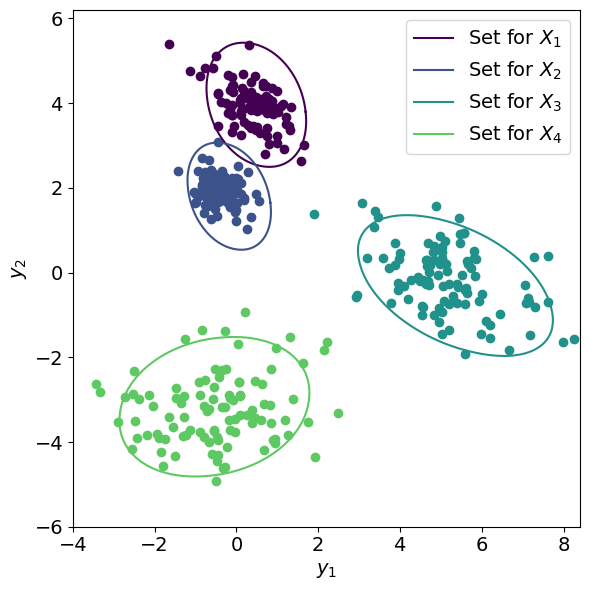

In [10]:
tab_seed = [2, 3, 16, 18]
tab_seed = [6, 15, 14, 26]

if model_final_loss_calibration < warm_start_model_loss_calibration:
        model_cov = ellipsoid_predictor.model
else:
        model_cov = warm_start_model

fig, ax = plt.subplots(figsize=(6, 6))

color_map = plt.cm.get_cmap('viridis', 5)
for i, seed in enumerate(tab_seed): 
        seed_everything(seed)
        x_specific, y_specific = data_generator.generate_specific_x(100)
        x_specific_tensor = torch.tensor(x_specific, dtype=torch.float32)
        y_specific_tensor = torch.tensor(y_specific, dtype=torch.float32)

        ellipsoid_coverage = ellipsoid_predictor.get_coverage(x_test=x_specific_tensor, y_test=y_specific_tensor)
        covariance_coverage = covariance_predictor.get_coverage(x_test=x_specific_tensor, y_test=y_specific_tensor)
        local_covariance_coverage = local_covariance_predictor.get_coverage(x_test=x_specific_tensor, y_test=y_specific_tensor)
        # volume_hyper_rectangle, coverage_hyper_rectangles = hyper_rectangle_predictor.calculate_volume_and_coverage(x_specific, y_specific)


        q_val = ellipsoid_predictor.q.item()
        f_x_specific_np = ellipsoid_predictor.model(x_specific_tensor).detach().numpy()
        Lambdas_specific_np = ellipsoid_predictor.get_Lambdas(x_specific_tensor).detach().numpy()
        f_x_specific_cov_np = model_cov(x_specific_tensor).detach().numpy()
        Lambdas_specific_cov_np = covariance_predictor.Lambda_cov.unsqueeze(0).expand(x_specific.shape[0], k, k).clone().detach().numpy()
        
        # Lambda_DC, mu_DC = DC_alg.get_Lambdas(x_specific_tensor.numpy())
        # f_x_DC = DC_alg.model(x_specific_tensor).detach().numpy() + mu_DC

        # ax = add_ellipse(ax,  f_x_DC[1], Lambda_DC[1], DC_alg.q.item(), DC_alg.nu.item(), color = "green", label='DC Ellipse')
        print(1/np.linalg.det(Lambdas_specific_np[i]), seed)
        print(ellipsoid_predictor.get_coverage(x_test=x_specific_tensor, y_test=y_specific_tensor), seed)
        ax.scatter(y_specific[:, 0], y_specific[:, 1], label=None, c = color_map(i))
        ax = add_ellipse(ax,  f_x_specific_np[1], Lambdas_specific_np[i], q_val, ellipsoid_predictor.nu_conformal.item(), color = color_map(i), label = fr'Set for $X_{{{i+1}}}$' )
        # ax = add_ellipse(ax,  f_x_specific_cov_np[1], Lambdas_specific_cov_np[1], 2, covariance_predictor.nu_covariance.item(), color = "green", label='Conformal Ellipse Cov')
        # ax = add_hyper_rectangle(ax, hyper_rectangle_predictor, x_specific[1])

        # ax.grid(True)
        # ax.legend( loc = "best")
        # remove the legend
        # ax.legend().remove()

        ax.set_xlabel(r'$y_1$', fontsize=14)
        ax.set_ylabel(r'$y_2$', fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        ax.legend(fontsize=14)
        ax.set_xlim(-4, 8.4)
        ax.set_ylim(-6, 6.2)
plt.tight_layout()
plt.savefig(f"../figs/3.1torch_ellipses_gaussian_cov_mov_p={ellipsoid_predictor.q.item():.2f}.pdf", dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close()


/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_53508/3548718367.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', 5)
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_53508/3548718367.py:28: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y_specific[:, 0], y_specific[:, 1], label=None, c = color_map(i))


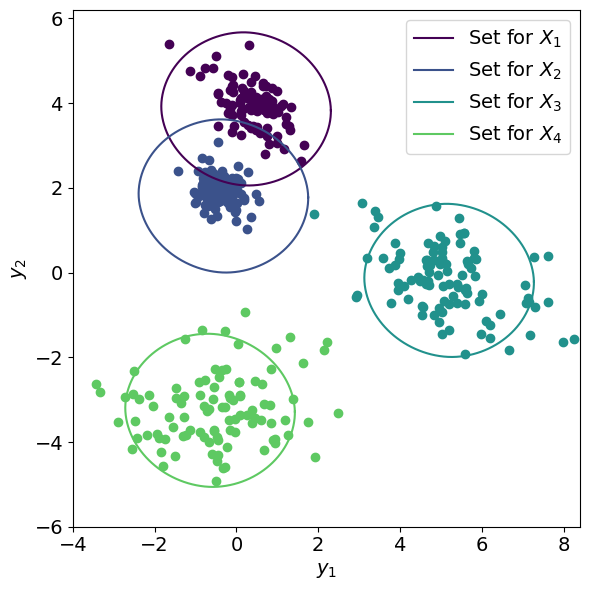

In [11]:
tab_seed = [6, 15, 14, 26]

if model_final_loss_calibration < warm_start_model_loss_calibration:
        model_cov = ellipsoid_predictor.model
else:
        model_cov = warm_start_model

fig, ax = plt.subplots(figsize=(6, 6))

color_map = plt.cm.get_cmap('viridis', 5)
for i, seed in enumerate(tab_seed): 
        seed_everything(seed)
        x_specific, y_specific = data_generator.generate_specific_x(100)
        x_specific_tensor = torch.tensor(x_specific, dtype=torch.float32)
        y_specific_tensor = torch.tensor(y_specific, dtype=torch.float32)

        ellipsoid_coverage = ellipsoid_predictor.get_coverage(x_test=x_specific_tensor, y_test=y_specific_tensor)
        covariance_coverage = covariance_predictor.get_coverage(x_test=x_specific_tensor, y_test=y_specific_tensor)
        local_covariance_coverage = local_covariance_predictor.get_coverage(x_test=x_specific_tensor, y_test=y_specific_tensor)
        # volume_hyper_rectangle, coverage_hyper_rectangles = hyper_rectangle_predictor.calculate_volume_and_coverage(x_specific, y_specific)


        q_val = ellipsoid_predictor.q.item()
        f_x_specific_np = one_lambda_predictor.model(x_specific_tensor).detach().numpy()
        

        ax = add_ellipse(ax,  f_x_specific_np[1], one_lambda_predictor.Lambda, one_lambda_predictor.q, one_lambda_predictor.nu, color = color_map(i), label = fr'Set for $X_{{{i+1}}}$')
        ax.scatter(y_specific[:, 0], y_specific[:, 1], label=None, c = color_map(i))
        # ax = add_ellipse(ax,  f_x_specific_np[1], Lambdas_specific_np[i], q_val, ellipsoid_predictor.nu_conformal.item(), color = color_map(i), label = fr'Set for $X_{{{i+1}}}$' )
        # ax = add_ellipse(ax,  f_x_specific_cov_np[1], Lambdas_specific_cov_np[1], 2, covariance_predictor.nu_covariance.item(), color = "green", label='Conformal Ellipse Cov')
        # ax = add_hyper_rectangle(ax, hyper_rectangle_predictor, x_specific[1])

        # ax.grid(True)
        # ax.legend( loc = "best")
        # remove the legend
        # ax.legend().remove()
        ax.set_xlabel(r'$y_1$', fontsize=14)
        ax.set_ylabel(r'$y_2$', fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        ax.legend(fontsize=14)
        ax.set_xlim(-4, 8.4)
        ax.set_ylim(-6, 6.2)
plt.tight_layout()
plt.savefig(f"../figs/2.3one_lambda_ellipses_gaussian_cov_mov_p={one_lambda_predictor.q:.2f}.pdf", dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close()
